# CSE527 Homework 3
**Due date: 23:59 on 11/06, 2018 (Tuesday)**

## Description
---
In this homework, we will examine the task of scene recognition starting with
very simple methods: tiny images and nearest neighbor classification, and then
move on to more advanced methods: bags of quantized local features and linear
classifiers learned by support vector machines.

Bag of words models are a popular technique for image classification inspired by
models used in natural language processing. The model ignores or downplays word
arrangement (spatial information in the image) and classifies based on a
histogram of the frequency of visual words. The visual word "vocabulary" is
established by clustering a large corpus of local features. See Szeliski chapter
14.4.1 for more details on category recognition with quantized features. In
addition, 14.3.2 discusses vocabulary creation and 14.1 covers classification
techniques.

For this homework you will be implementing a basic bag of words model. You will
classify scenes into one of 15 categories by training and testing on the 15
scene database (introduced in [Lazebnik et al.
2006](http://www.di.ens.fr/willow/pdfs/cvpr06b.pdf), although built on top of
previously published datasets).
[Lazebnik et al. 2006](http://www.di.ens.fr/willow/pdfs/cvpr06b.pdf) is a great
paper to read, although we will be implementing the baseline method the paper
discusses (equivalent to the zero level pyramid) and not the more sophisticated
spatial pyramid. For an excellent survey of
pre-deep-learning feature encoding methods for bag of words models, see
[Chatfield et al, 2011](http://www.robots.ox.ac.uk/~vgg/research/encoding_eval/).

You are required to implement 2 different image representations: tiny images and bags of SIFT features, and 2 different classification techniques: nearest neighbor and linear SVM. There are 3 problems plus a performance report in this homework with a total of 100 points. 1 bonus question with extra 10 points is provided under problem 3. The maximum points you may earn from this homework is 100 + 10 = 110 points. Be sure to read **Submission Guidelines** below. They are important.

## Dataset
---
The starter code trains and tests on 100 images from each category (i.e. 1500
training examples total and 1500 test cases total). In a real research paper,
one would be expected to test performance on random splits of the data into
training and test sets, but the starter code does not do this to ease debugging.
Download the dataset
[here](https://drive.google.com/a/cs.stonybrook.edu/file/d/0B446EB1iI6_Qc0Q1NTRTajdUVTg/view?usp=sharing). <br>

Once downloded, extract it to your root folder Surname_Givenname_SBUID. Under your root folder,
there should be a folder named "data" (i.e. XXX/Surname_Givenname_SBUID/data) containing the images.
**Delete** the data subfolder before submission or the blackboard won't let you do so because
of the size. There should be only one .ipynb file under your root folder Surname_Givenname_SBUID.


## Starter Code
---
To make your task a little easier, below we provide some starter code which
randomly guesses the category of every test image and achieves about 6.6% accuracy
(1 out of 15 guesses is correct).

In [1]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import itertools
import os

In [3]:
class_names = [name[11:] for name in glob.glob('data/train/*')]
class_names = dict(zip(xrange(len(class_names)), class_names))

def load_dataset(path, num_per_class=-1):
    data = []
    labels = []
    for id, class_name in class_names.iteritems():
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            data.append(cv2.imread(filename, 0))
    return data, labels

# load training dataset
train_data, train_label = load_dataset('data/train/')
#train_num = len(train_label)

# load testing dataset
test_data, test_label = load_dataset('data/test/', 100)
#test_num = len(test_label)

# feature extraction
def extract_feat(raw_data):
    feat_dim = 256
    feat = np.zeros((len(raw_data), feat_dim), dtype=np.float32)
    for i in xrange(feat.shape[0]):
        feat[i] = np.reshape(raw_data[i], (raw_data[i].size))[:feat_dim] # dummy implemtation
        
    return feat

train_feat = extract_feat(train_data)
test_feat = extract_feat(test_data)

# model training: take feature and label, return model
def train(X, Y):
    return 0 # dummy implementation

# prediction: take feature and model, return label
def predict(model, x):
    return np.random.randint(15) # dummy implementation

# evaluation
predictions = [-1]*len(test_feat)
for i in xrange(test_num):
    predictions[i] = predict(None, test_feat[i])
    
accuracy = sum(np.array(predictions) == test_label) / float(test_num)

print "The accuracy of my dummy model is {:.2f}%".format(accuracy*100)

1500
1500
The accuracy of my dummy model is 6.07%


## Problem 1: Tiny Image Representation + Nearest Neighbor Classifier
{25 points} You will start by implementing the tiny image representation and the nearest neighbor classifier. They are easy to understand, easy to implement, and run very quickly for our experimental setup.

The "tiny image" feature is one of the simplest possible image representations. One simply resizes each image to a small, fixed resolution. You are required to **resize the image to 16x16**. It works slightly better if the tiny image is made to have zero mean and unit length (normalization). This is not a particularly good representation, because it discards all of the high frequency image content and is not especially invariant to spatial or brightness shifts. We are using tiny images simply as a baseline.

The nearest neighbor classifier is equally simple to understand. When tasked with classifying a test feature into a particular category, one simply finds the "nearest" training example (L2 distance is a sufficient metric) and assigns the label of that nearest training example to the test example. The nearest neighbor classifier has many desirable features — it requires no training, it can learn arbitrarily complex decision boundaries, and it trivially supports multiclass problems. It is quite vulnerable to training noise, though, which can be alleviated by voting based on the K nearest neighbors (but you are not required to do so). Nearest neighbor classifiers also suffer as the feature dimensionality increases, because the classifier has no mechanism to learn which dimensions are irrelevant for the decision.

Report your classification accuracy on the test sets and time consumption.

**Hints**:
- Use [cv2.resize()](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html#resize) to resize the images;
- Use [NearestNeighbors in Sklearn](http://scikit-learn.org/stable/modules/neighbors.html) as your nearest neighbor classifier.

In [53]:
# Write your codes here
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import norm
from time import time


#N = size(image_paths, 1);
train_feats = np.zeros((train_num, 256));
for i in range(train_num):    
    resized = cv2.resize(train_data[i], (16,16))
    train_feats[i] = np.reshape(resized, (1, 256))
    train_feats[i] = train_feats[i] - np.mean(train_feats[i])
    train_feats[i] = cv2.normalize(train_feats[i], train_feats[i], 0, 255, cv2.NORM_MINMAX)

test_feats = np.zeros((test_num, 256));
for i in range(test_num):    
    resized = cv2.resize(test_data[i], (16,16))
    test_feats[i] = np.reshape(resized, (1, 256))
    test_feats[i] = test_feats[i] - np.mean(test_feats[i])
    test_feats[i] = cv2.normalize(test_feats[i], test_feats[i], 0, 255, cv2.NORM_MINMAX)

#Using k nearest neighbours
neigh = KNeighborsClassifier(n_neighbors=3, weights='distance', p=2)

t0=time()
neigh.fit(train_feats, train_label)
print("training time:", round(time()-t0, 3), "s")

t1=time()
test_pred = neigh.predict(test_feats)
print("prediction time:", round(time()-t1, 3), "s")

accuracy = np.sum(test_pred == test_label) / float(test_num)
print "The accuracy of tiny images model is {:.2f}%".format(accuracy*100)

('training time:', 0.012, 's')
('prediction time:', 1.306, 's')
The accuracy of tiny images model is 18.87%


# Problem 2: Bag of SIFT Representation + Nearest Neighbor Classifer
{35 points}
After you have implemented a baseline scene recognition pipeline it is time to
move on to a more sophisticated image representation — bags of quantized SIFT
features. Before we can represent our training and testing images as bag of
feature histograms, we first need to establish a vocabulary of visual words. We
will form this vocabulary by sampling many local features from our training set
(10's or 100's of thousands) and then cluster them with k-means. The number of
k-means clusters is the size of our vocabulary and the size of our features. For
example, you might start by clustering many SIFT descriptors into k=50 clusters.
This partitions the continuous, 128 dimensional SIFT feature space into 50
regions. For any new SIFT feature we observe, we can figure out which region it
belongs to as long as we save the centroids of our original clusters. Those
centroids are our visual word vocabulary. Because it can be slow to sample and
cluster many local features, the starter code saves the cluster centroids and
avoids recomputing them on future runs.

Now we are ready to represent our training and testing images as histograms of
visual words. For each image we will densely sample many SIFT descriptors.
Instead of storing hundreds of SIFT descriptors, we simply count how many SIFT
descriptors fall into each cluster in our visual word vocabulary. This is done
by finding the nearest neighbor k-means centroid for every SIFT feature. Thus,
if we have a vocabulary of 50 visual words, and we detect 220 distinct SIFT
features in an image, our bag of SIFT representation will be a histogram of 50
dimensions where each bin counts how many times a SIFT descriptor was assigned
to that cluster. The total of all the bin-counts is 220. The histogram should be
normalized so that image size does not dramatically change the bag of features
magnitude.

**Note**: 
- Instead of using SIFT to detect invariant keypoints which is time-consuming,
  you are recommended to densely sample keypoints in a grid with certain step
  size (sampling density) and scale.
- There are many design decisions and free parameters for the bag of SIFT
  representation (number of clusters, sampling density, sampling scales, SIFT
  parameters, etc.) so accuracy might vary from 50% to 60%.
- Indicate clearly the parameters you use along with the prediction accuracy
  on test set and time consumption.

**Hints**:
- Use [KMeans in Sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
  to do clustering and find the nearest cluster centroid for each SIFT feature;
- Use `cv2.xfeatures2d.SIFT_create()` to create a SIFT object;
- Use `sift.compute()` to compute SIFT descriptors given densely sampled keypoints
  ([cv2.Keypoint](https://docs.opencv.org/3.0-beta/modules/core/doc/basic_structures.html?highlight=keypoint#keypoint)).

In [36]:
# Write your codes here
#from sklearn.cluster import KMeans
from scipy.cluster.vq import *

# initialize SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
train_descriptors = []
for img in train_data:
    kp1, des1 = sift.detectAndCompute(img, None)
    train_descriptors.append((kp1,des1))

train_des_list = train_descriptors[0][1]
for kp, des in train_descriptors[1:]:
    train_des_list = np.vstack((train_des_list, des))

#Performing kmeans clustering
vocab, variance = kmeans(train_des_list, 100, 1) 

im_features = np.zeros((train_num, 100), "float32")
for i in xrange(train_num):
    words, distance = vq(train_descriptors[i][1],vocab)
    for w in words:
        im_features[i][w] += 1

In [37]:
#Test data

test_descriptors = []
for img in test_data:
    kp2, des2 = sift.detectAndCompute(img, None)
    test_descriptors.append((kp2, des2))
    
test_des_list = test_descriptors[0][1]
for kp, des in test_descriptors[0:]:
    test_des_list = np.vstack((test_des_list, des))
    
test_features = np.zeros((test_num, 100), "float32")
for i in xrange(test_num):
    words, distance = vq(test_descriptors[i][1],vocab)
    for w in words:
        test_features[i][w] += 1

In [46]:
# k-Nearest neighbor model
t0 = time()
BoW_neigh = KNeighborsClassifier(n_neighbors=20, weights='distance', p=2) #, algorithm='kd_tree', leaf_size=40
BoW_neigh.fit(im_features, train_label)
print("training time:", round(time()-t0, 3), "s")

t1= time()
test_pred2 = BoW_neigh.predict(test_features)
print("Prediction time:", round(time()-t1, 3), "s")

accuracy = np.sum(test_pred2 == test_label) / float(test_num)
print "The accuracy of BoW with nearest neighbor model is {:.2f}%".format(accuracy*100)

('training time:', 0.011, 's')
('Prediction time:', 0.502, 's')
The accuracy of BoW with nearest neighbor model is 45.67%


## Problem 3: Bag of SIFT Representation + one-vs-all SVMs
{20 points}
The last task is to train one-vs-all linear SVMS to operate in the bag of SIFT
feature space. Linear classifiers are one of the simplest possible learning
models. The feature space is partitioned by a learned hyperplane and test cases
are categorized based on which side of that hyperplane they fall on. Despite
this model being far less expressive than the nearest neighbor classifier, it
will often perform better.

You do not have to implement the support vector machine. However, linear
classifiers are inherently binary and we have a 15-way classification problem
(the library has handled it for you). To decide which of 15 categories a test
case belongs to, you will train 15 binary, one-vs-all SVMs. One-vs-all means
that each classifier will be trained to recognize 'forest' vs 'non-forest',
'kitchen' vs 'non-kitchen', etc. All 15 classifiers will be evaluated on each
test case and the classifier which is most confidently positive "wins". E.g. if
the 'kitchen' classifier returns a score of -0.2 (where 0 is on the decision
boundary), and the 'forest' classifier returns a score of -0.3, and all of the
other classifiers are even more negative, the test case would be classified as a
kitchen even though none of the classifiers put the test case on the positive
side of the decision boundary. When learning an SVM, you have a free parameter
$\lambda$ (lambda) which controls how strongly regularized the model is. Your
accuracy will be very sensitive to $\lambda$, so be sure to try many values.

Indicate clearly the parameters you use along with the prediction accuracy on
test set and time consumption.

**Bonus {10 points}**: 10 points will be given to students whose accuracy
  ranks top 3 in this homework. Don't cheat and don't train your model on
  testing data, a separate testing dataset will be used to evaluate your model.

**Hints**:
- Use SVM in
  [Sklearn](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm)
  (recommended) or
  [OpenCV](https://docs.opencv.org/3.0-alpha/modules/ml/doc/support_vector_machines.html)
  to do training and prediction.

In [8]:
# Write your codes here
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

#Grid search - for hyper-paramter tuning
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(im_features, train_label)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 10.0, 'gamma': 0.0001} with a score of 0.53


In [52]:
t0 = time()
clf = SVC(C=10, gamma=0.0001, decision_function_shape='ovr', random_state=0)
clf.fit(im_features, train_label)
print("training time:", round(time()-t0, 3), "s")

t1 = time()
svm_test_pred =  clf.predict(test_features) 
print("Prediction time:", round(time()-t1, 3), "s")

accuracy = np.sum(svm_test_pred == test_label) / float(test_num)
print "The accuracy of BoW with SVM is {:.2f}%".format(accuracy*100)

('training time:', 0.315, 's')
('Prediction time:', 0.367, 's')
The accuracy of BoW with SVM is 53.27%


## Performance Report
---
{20 points}
Please report the performance of the following combinations **in the given order**
in terms of the time consumed and classification accuracy. Describe your algorithm,
any decisions you made to write your algorithm in your particular way, and how
different choices you made affect it. Compute and draw a (normalized) [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix), and discuss
where the method performs best and worse for each of the combination.
Here is an [example](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py) of how to compute confusion matrix.


1st: Tiny images representation and nearest neighbor classifier (accuracy of about 18-25%).<br>
2nd: Bag of SIFT representation and nearest neighbor - classifier (accuracy of about 50-60%). <br>
3rd: Bag of SIFT representation and linear SVM classifier (accuracy of about 60-70%). <br>

**First combination:** <br>

-- Time consumed and prediction accuracy

-- Algorithm descriptions and discussions

-- Confusion matrix observations

**Second combination:** <br>

-- Time consumed and prediction accuracy

-- Algorithm descriptions and discussions

-- Confusion matrix observations

**Third combination:** <br>

-- Time consumed and prediction accuracy

-- Algorithm descriptions and discussions

-- Confusion matrix observations

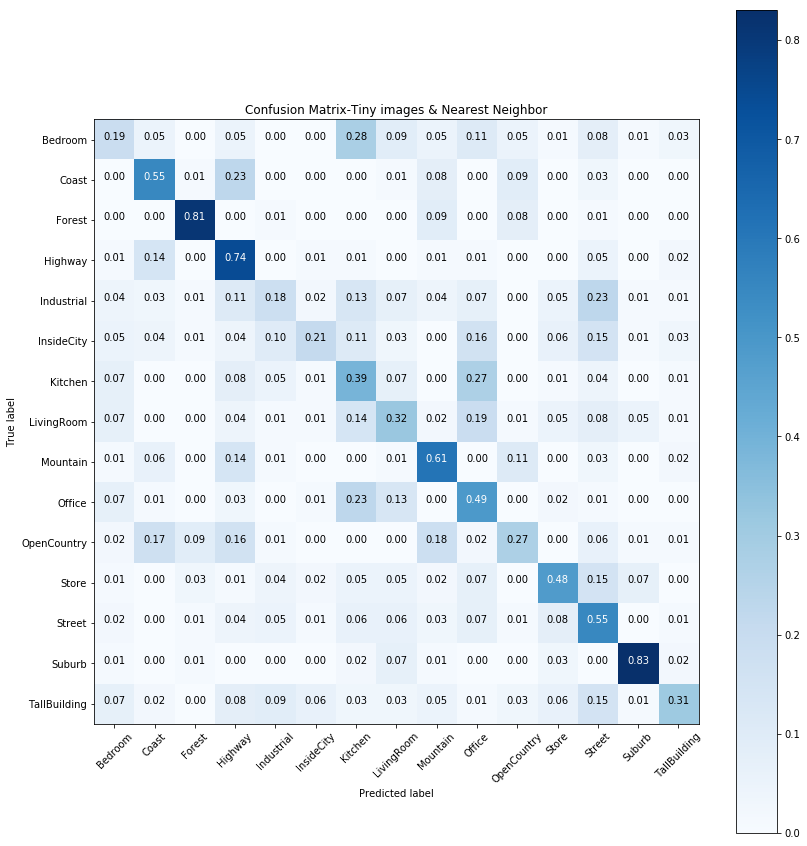

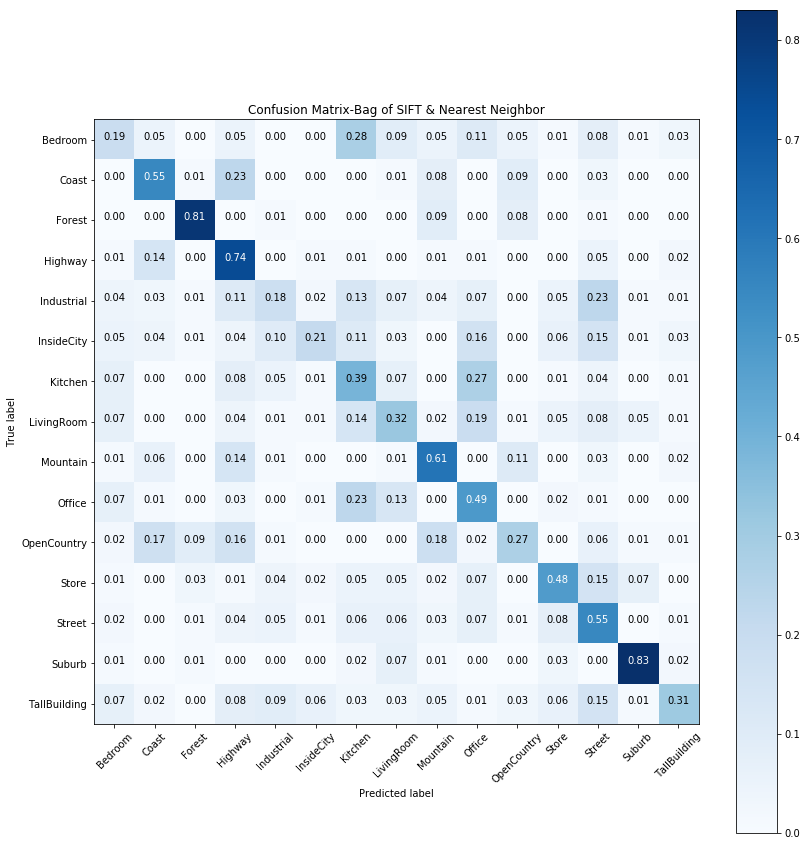

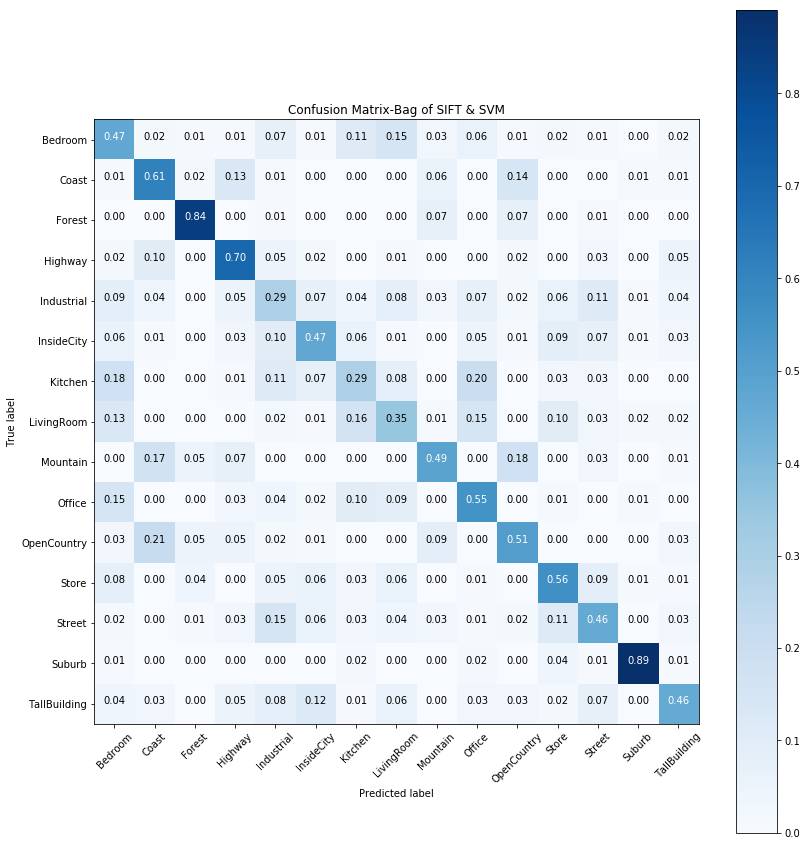

In [374]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues): 
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

c_names = [name[11:] for name in glob.glob('data/train/*')]


#First combination:
# Confusion matrix
cm1 = confusion_matrix(test_label, test_pred)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cm1, c_names, normalize=True, title='Confusion Matrix-Tiny images & Nearest Neighbor')
plt.show()

#Second combination:
# Confusion matrix
cm2 = confusion_matrix(test_label, test_pred2)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cm2, c_names, normalize=True, title='Confusion Matrix-Bag of SIFT & Nearest Neighbor')
plt.show()

#Third combination:
# Confusion matrix
cm3 = confusion_matrix(test_label, svm_test_pred)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cm3, c_names, normalize=True, title='Confusion Matrix-Bag of SIFT & SVM')
plt.show()

## Report

**1st Combination: Tiny images representation and nearest neighbor classifier** <br>
Training time: 0.012 seconds <br>
Prediction time: 1.306 seconds <br>
Accuracy: 18.87% <br>

I normalized the tiny images after resizing them to 16x16. I observed that training takes longer than prediction which is true for Nearest Neighbor model. I used k-Nearest Neighbor classifier. I tried different values of k (n_neighbors). The accuracy for different k's are as follows:

|k Value         |          ACCURACY|
|----------------|------------------|
|1               |            18.13%|
|3               |            18.87%|
|4               |            17.73%|
|8               |            17.53%|
|15              |            17.20%|

The accuracy was highest for k = 3. I set the weights parameter to 'distance' so that the closer neighbors have greater influence than the further away neighbors. I set the power parameter to 2 which indicates Euclidean distance(L2). I found that accuracy was higher for L2 than for Manhattan distance (L1). 

<b>Confusion matrix observation</b>: The diagonal elements represent the number of times the predicted label and the true label are equal. For this combination, forest, highway and suburb are the top 3 correctly classified categories. There are a lot of misclassified categories. For example, bedroom is highly misclassified as kitchen, kitchen is highly misclassified as office and industrial is misclassfied as street.

**2nd Combination: Bag of SIFT representation and Nearest Neighbor classifier** <br>
Training time: 0.01 seconds <br>
Prediction time: 0.502 seconds <br>
Accuracy: 45.67% <br>

The training time does not include the time for generating the clusters of centroids. I generated the SIFT descriptors and clustered them using kMeans clustering. I tried different cluster sizes. The accuracy was highest for cluster size = 100 and numbe of neighbors = 20. The results are as follows: <br>

|Cluster size  |  Value of k   |   Accuracy|
|--------------|---------------|-----------|
|50            |              1|     36.53%|
|50            |             10|      44.0%|
|50            |             15|     45.13%|
|50            |             20|     44.80%|
|50            |             30|     44.73%|
|100           |              1|     37.07%|
|100           |             10|     45.27%|
|100           |             15|     45.07%|
|100           |             20|     45.67%|
|100           |             25|     45.20%|
|200           |              1|     36.60%|
|200           |             10|     41.93%|
|200           |             15|     42.53%|
|200           |             20|     42.93%|
|200           |             30|     42.00%|

As the cluster size increased, the accuracy on test data became better. Upon increasing the number of nearest neighbors as well, the accuracy increased. But on further increasing the number of nearest neighbors, accuracy decreased.

<b>Confusion matrix observation</b>: For this combination, forest, highway and suburb are the top 3 correctly classified categories. Bedroom was highly misclassified. There are lesser misclassified categories compared to the previous combination with tiny images.

**3rd Combination: Bag of SIFT representation and one-vs-all SVM classifier** <br>
Training time: 0.315 seconds <br>
Prediction time: 0.367 seconds <br>
Accuracy: 53.27% <br>

I trained SVM by setting the parameter decision_function_shape as 'ovr'(one-versus-rest) which is equivalent to training 15 one-vs-all SVMs. I experimented with different cluster sizes. I did Grid Search to identify the best parameters (C and gamma) for SVM for the different cluster sizes. The training time does not include the time taken to perform the grid search. C behaves as a regularization parameter and the model was sensitive to C. As the value of C increased, accuracy got better. But for C values greater than 10, the accuracy did not get any better. <br>

The final model I built was for cluster size of 100. The results are as follows:

<b>Cluster size : 50</b> <br> C = 10.0  <br> gamma = 0.0001 <br> Accuracy = 43.23%<br> <br>
<b>Cluster size : 100</b> <br> C = 10.0 <br> gamma = 0.0001 <br> Accuracy = 53.27% <br> <br>
<b>Cluster size : 200</b> <br> C = 10.0 <br> gamma = 0.0001 <br> Accuracy = 53.93% <br>

As the cluster size increased, the accuracy of the model got better. Accuracy for cluster size of 100 and 200 differed by very small value. <br>

<b>Confusion matrix observation</b>: For this combination, forest, suburb and highway are the top 3 correctly classfied categories. The number of misclassified categories are even lesser than that of Bag of SIFT and Nearest Neighbor combination.
In the previous combination, bedroom was correctly classified for only 19 images. But, in this combination 47 images are correctly classifed. For opencountry, in the previous combination 27 were correctly classified. But in this combination, 51 are correctly classified. The number of images correctly classfied are almost double in several other categories as well.

## Submission guidelines
---
Extract the downloaded .zip file to a folder of your preference. The input and output paths are predefined and **DO NOT** change them. The image read and write functions are already written for you. 

When submitting your .zip file through blackboard, please <br> 
-- name your .zip file as Surname_Givenname_SBUID (example: Trump_Donald_11113456). <br>
-- DO NOT change the folder structre, please just fill in the blanks. <br>

You are encouraged to make posts and answer questions on Piazza. Due to the amount of emails I receive from past years, it is unfortunate that I won't be able to reply all your emails. Please ask questions on Piazza and send emails only when it is private.

To encourage you to answer questions on piazza, the three persons answering the most questions will be awarded extra 5 points at the end of the semester.

If you alter the folder strucutres, the grading of your homework will be significantly delayed and possibly penalized. And I **WILL NOT** reply to any email regarding this matter.

Be aware that your codes will undergo plagiarism checker both vertically and horizontally. Please do your own work.

Late submission penalty: <br>
There will be a 10% penalty per day for late submission. However, you will have 3 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period. All late penalties incurred will be applied to your scores at the end of the semester.

Some important things to note: <br>
A correct pipeline for your submitted folder structure: <br>
1) Download the .zip file from blackboard and unzip it (e.g. CSE527-HW1-Fall18.zip) <br>
2) The unzipped folder should have name like CSE527-HW1-Fall18, rename it to Surname_Givenname_SBUID <br>
3) Write your codes in the given .ipynb file <br>
4) Save the visual outputs in the .ipynb file <br>
5) Rezip your Surname_Givenname_SBUID folder and submit <br>

**2 credits will be deducted** from HW2 and onwards if:
1) The unzipped folder still have name like CSE527-HW1-Fall18 <br>
2) There is a nested folder named CSE527-HW1-Fall18 under your Surname_Givenname_SBUID folder <br>
3) You zipped sub-folders and .ipynb directly without providing a root folder called Surname_Givenname_SBUID <br>
4) There are more than one .ipynb file under your folder (people who did this didn't receive a score for HW1) <br>
5) The naming didn't conform to Surname_Givenname_SBUID <br>
6) You didn't save the visual outputs inside your .ipynb file <br>

REFERENCES <br>

1. http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier 
2. https://scikit-learn.org/stable/auto_examples/svm/plot_svm_scale_c.html
3. https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
4. https://docs.scipy.org/doc/scipy-0.7.x/reference/cluster.vq.html